In [1]:
from src.meu_framework import AutoClassificationEngine
import pandas as pd
import numpy as np

/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No path specified. Models will be saved in: "AutogluonModels/ag-20260219_133635"
Verbosity: 2 (Standard Logging)


🌸 Carregando Iris Dataset...
🎯 Target binário criado: 1 se Virginica, 0 se Outros
🧪 Injetando ruído para testar a blindagem do framework...

⚙️ Inicializando Engine...

🚀 --- TREINAMENTO INICIADO ---

📋 RESUMO DA FILTRAGEM DE VARIÁVEIS:
   => Removidas por Leakage (100% obvias): Nenhuma
   => Removidas por Alta Cardinalidade:    Nenhuma
   => Removidas por Colinearidade (>90%):  ['petal width (cm)']
   => Features Finais Mantidas (4): ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'region']

🎯 Métrica Otimizada: average_precision | Preset: best_quality


=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.2.0: Tue Nov 18 21:08:48 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T8132
CPU Count:          10
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       7.24 GB / 16.00 GB (45.3%)
Disk Space Avail:   373.19 GB / 460.43 GB (81.1%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by st


✅ Modelo Treinado.

🏆 Melhores Modelos (Top 3):
                     model  score_val  pred_time_val
0  RandomForestEntr_BAG_L1   0.900484       0.048824
1  RandomForestGini_BAG_L1   0.934293       0.049295
2        LightGBMXT_BAG_L2   0.892135       0.103995

📊 Gerando Relatório Visual Completo (Treino vs Teste)...


/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/gabrielsales/Documents/Projetos/tpot_examspred/src/meu_framework.py:386: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


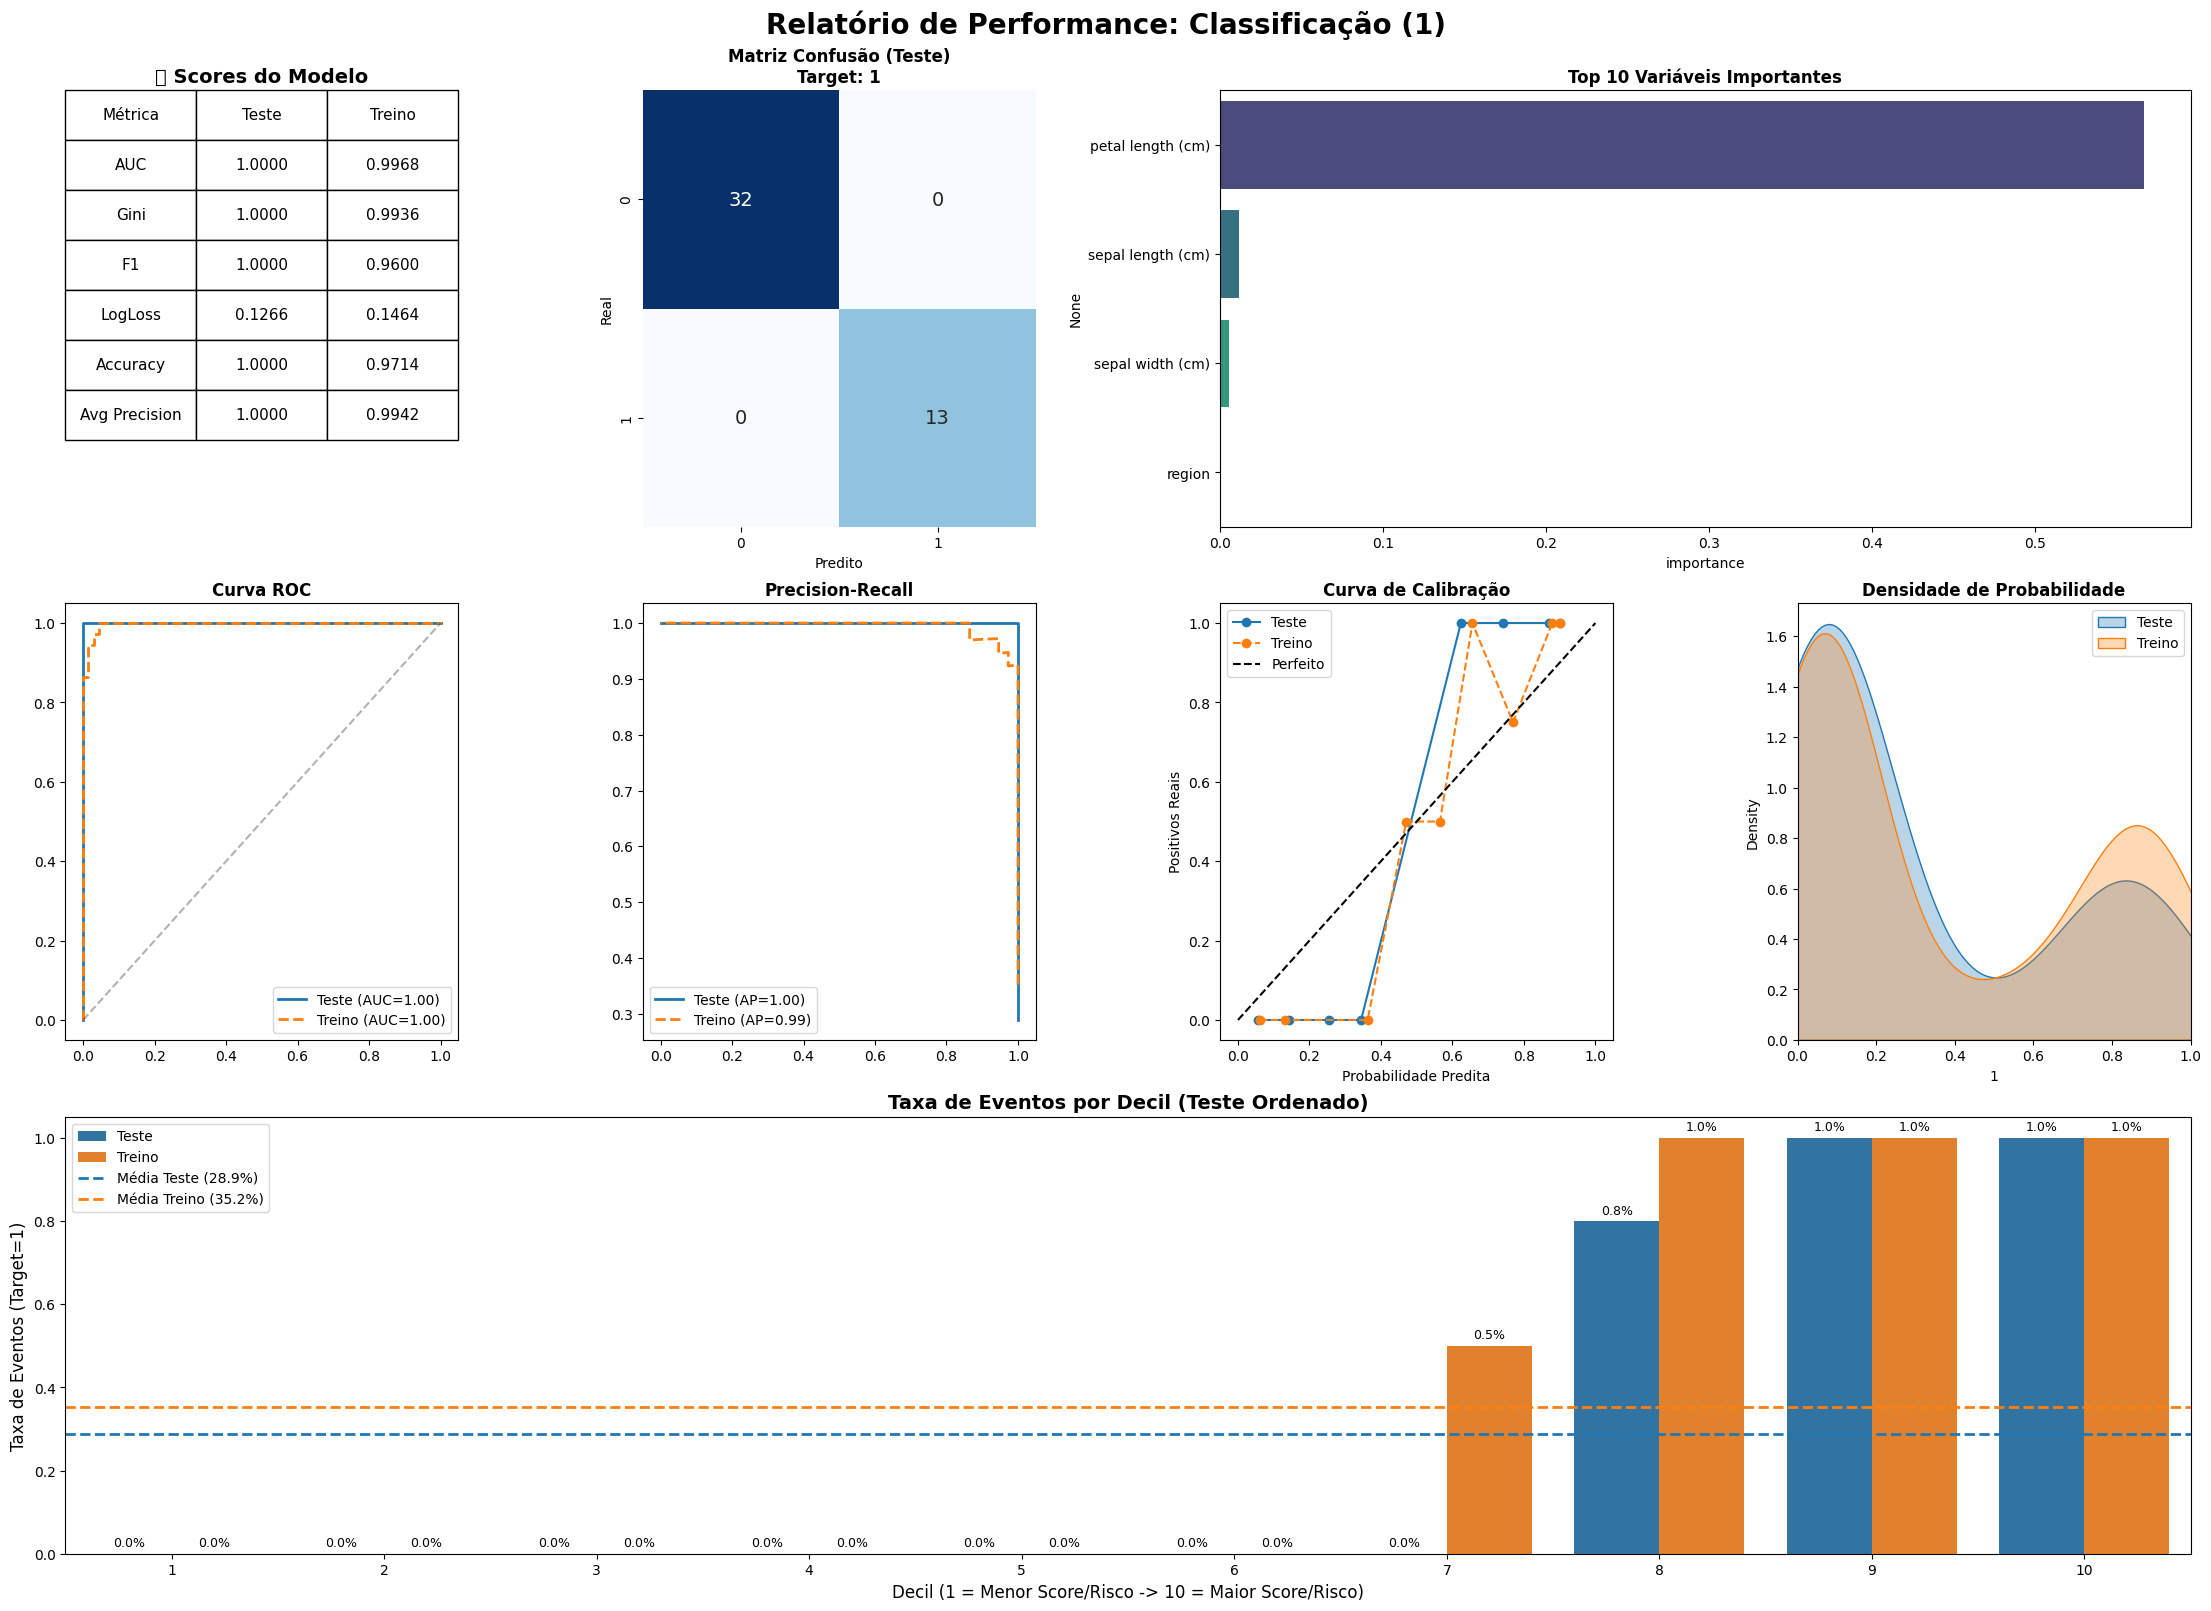

📦 Bundle salvo em modelo_iris_teste

✅ Teste finalizado com sucesso!


In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


def create_messy_iris():
    """Cria uma versão 'suja' do Iris para testar a robustez do pipeline."""
    print("🌸 Carregando Iris Dataset...")
    data = load_iris()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df["target"] = data.target

    # 1. TRANSFORMAÇÃO BINÁRIA
    # O framework tem gráficos avançados (ROC, Lift) que brilham em classificação binária.
    # Vamos prever se é 'Virginica' (classe 2) ou não.
    df["target"] = df["target"].apply(lambda x: 1 if x == 2 else 0)
    print("🎯 Target binário criado: 1 se Virginica, 0 se Outros")

    # 2. INJEÇÃO DE "SUJEIRA" (Para testar o saneamento)
    print("🧪 Injetando ruído para testar a blindagem do framework...")

    # A. Inserir Nulos (Teste do SimpleImputer)
    df.loc[0:10, "sepal length (cm)"] = np.nan
    df.loc[5:15, "petal width (cm)"] = None  # None do Python

    # B. Inserir Outliers Extremos (Teste do Winsorization/Log)
    # Valor absurdo para ver se o _handle_outliers_and_log corta
    df.loc[20, "sepal width (cm)"] = 150.0

    # C. Inserir Coluna de Alta Cardinalidade (Teste do Sanity Check)
    # O framework deve avisar que isso parece um ID
    df["customer_id"] = [f"ID_{i}" for i in range(len(df))]

    # D. Inserir Categoria com Rótulos Raros (Teste do _handle_rare_labels)
    # 'A' é frequente, 'X' e 'Y' são raros (<1%)
    df["region"] = "North"
    df.loc[0:2, "region"] = "South_East_Extreme"  # Raro
    df.loc[3:5, "region"] = "West_Old_Village"  # Raro

    return df


# --- EXECUÇÃO ---

# 1. Preparar Dados
df = create_messy_iris()
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# 2. Definir Parâmetros
# Simulamos um cenário real onde queremos excluir o ID e forçar configurações
params = {
    "target": "target",
    "features_to_exclude": ["customer_id"],  # Deve remover a coluna de ID
    "pipeline_settings": {
        "use_pca": False,  # Testar integração com PCA
        "pca_components": 0.95,  # Manter 95% da variância
    },
    "force_types": {
        "category": ["region"]  # Garantir que 'region' seja tratada como categórica
    },
    "eval_metric": "average_precision",  # Métrica de avaliação personalizada
}

# 3. Instanciar Engine
print("\n⚙️ Inicializando Engine...")
engine = AutoClassificationEngine(params)

# 4. Treinar (Fit)
# time_limit curto apenas para teste rápido
leaderboard = engine.fit(train_df, time_limit=30)

print("\n🏆 Melhores Modelos (Top 3):")
print(leaderboard[["model", "score_val", "pred_time_val"]].head(3))

# 5. Gerar Relatórios Visuais
print("\n📊 Gerando Relatório Visual Completo (Treino vs Teste)...")
# ATUALIZADO: Passando train_df também para ver curvas comparativas
engine.plot_complete_report(test_df, train_data=train_df)

# 6. Salvar Pacote para Produção
engine.save_bundle("modelo_iris_teste")

print("\n✅ Teste finalizado com sucesso!")

No path specified. Models will be saved in: "AutogluonModels/ag-20260219_133713"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.2.0: Tue Nov 18 21:08:48 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T8132
CPU Count:          10
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       6.97 GB / 16.00 GB (43.6%)
Disk Space Avail:   373.18 GB / 460.43 GB (81.0%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyS

🚢 Carregando Dataset Titanic via Seaborn...
   Dimensões originais: (891, 15)
   Nulos por coluna:
age            177
embarked         2
deck           688
embark_town      2
dtype: int64

⚙️ Inicializando Engine de Classificação...

🚀 --- TREINAMENTO INICIADO ---

📋 RESUMO DA FILTRAGEM DE VARIÁVEIS:
   => Removidas por Leakage (100% obvias): Nenhuma
   => Removidas por Alta Cardinalidade:    Nenhuma
   => Removidas por Colinearidade (>90%):  Nenhuma
   => Features Finais Mantidas (9): ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'deck', 'alone']

🎯 Métrica Otimizada: average_precision | Preset: best_quality


Beginning AutoGluon training ... Time limit = 15s
AutoGluon will save models to "/Users/gabrielsales/Documents/Projetos/tpot_examspred/AutogluonModels/ag-20260219_133713/ds_sub_fit/sub_fit_ho"
Train Data Rows:    632
Train Data Columns: 8
Label Column:       survived
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7136.24 MB
	Train Data (Original)  Memory Usage: 0.16 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting


✅ Modelo Treinado.

🏆 Top 5 Modelos:
                     model  score_val  pred_time_val
0  RandomForestGini_BAG_L1   0.815338       0.084983
1  RandomForestEntr_BAG_L1   0.820689       0.061364
2    ExtraTreesGini_BAG_L1   0.790760       0.062680
3    ExtraTreesEntr_BAG_L1   0.784756       0.062597
4           XGBoost_BAG_L1   0.845854       0.039769

📊 Gerando Relatório Visual (Foco em Lift e ROC)...


/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/gabrielsales/Documents/Projetos/tpot_examspred/src/meu_framework.py:386: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


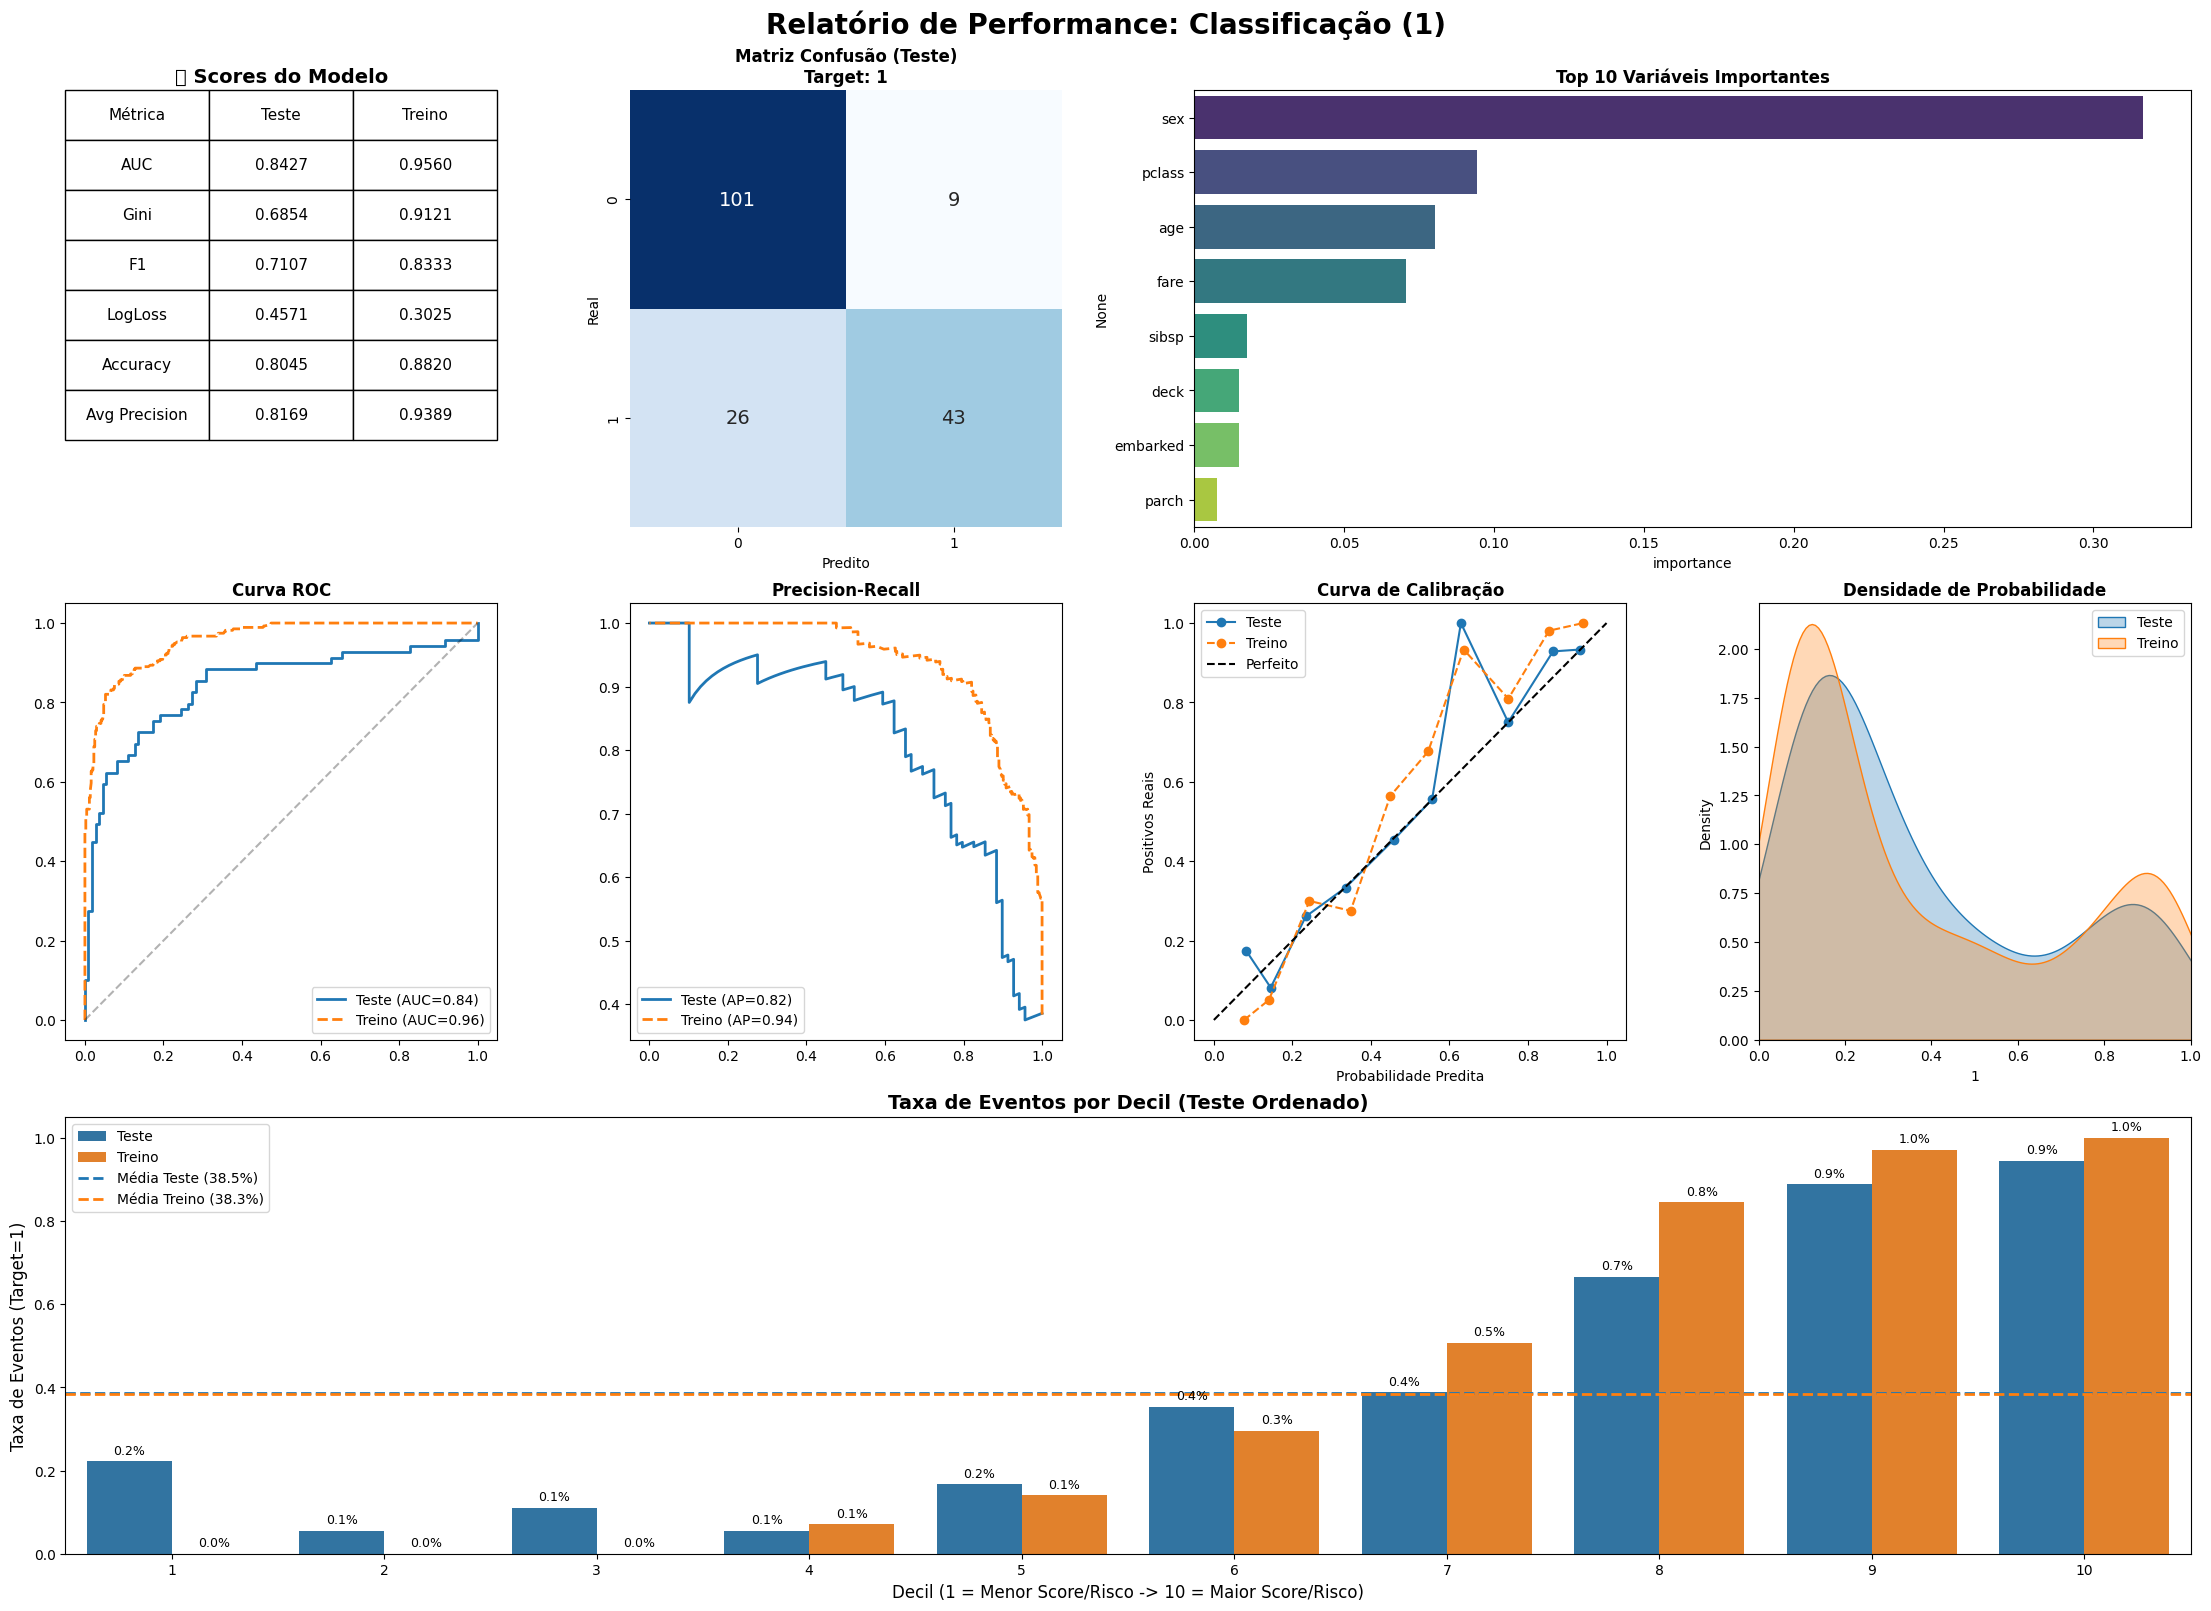

📦 Bundle salvo em modelo_titanic_prod

✅ Processo concluído. Verifique os gráficos para validar a estratégia 'Mulheres e Crianças primeiro'.


In [3]:
import seaborn as sns


def load_and_prep_titanic():
    print("🚢 Carregando Dataset Titanic via Seaborn...")
    # O dataset do seaborn já vem com algumas colunas redundantes que testam a inteligência do analista
    df = sns.load_dataset("titanic")

    # Visualizar a sujeira inicial
    print(f"   Dimensões originais: {df.shape}")
    print(f"   Nulos por coluna:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

    # Conversão de categorias object para string para garantir compatibilidade
    for col in df.select_dtypes(["object", "category"]).columns:
        df[col] = df[col].astype(str)

    return df


# --- EXECUÇÃO ---

# 1. Carregar Dados
df = load_and_prep_titanic()

# 2. Divisão Treino/Teste
# Stratify é importante aqui pois a taxa de sobrevivência não é balanceada (aprox 38%)
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["survived"]
)

# 3. Configuração dos Parâmetros (O "Cérebro" do Framework)
params = {
    "target": "survived",
    # AQUI ESTÁ O SEGREDO DO TITANIC:
    # 1. 'alive': É a resposta em texto (yes/nao). Se não tirar, é Data Leakage (acurácia vai a 100%).
    # 2. 'who', 'adult_male': Redundantes com Sex e Age.
    # 3. 'embark_town': Redundante com 'embarked'.
    # 4. 'deck': Tem muitos nulos, o framework vai tratar, mas as vezes preferimos tirar. Vamos deixar para testar o imputing.
    "features_to_exclude": ["alive", "who", "adult_male", "embark_town", "class"],
    "pipeline_settings": {
        "use_pca": False,  # Titanic tem poucas colunas, PCA pode atrapalhar a explicabilidade aqui
        "pca_components": 0.95,
    },
    # Forçar tipagem se necessário (o framework detecta bem, mas é bom ser explícito)
    "force_types": {"category": ["sex", "embarked", "deck", "pclass"]},
    "eval_metric": "average_precision",
}

# 4. Inicializar Engine
print("\n⚙️ Inicializando Engine de Classificação...")
engine = AutoClassificationEngine(params)

# 5. Treinar
# Aumentei um pouco o tempo pois o AutoGluon tenta modelos mais complexos
leaderboard = engine.fit(train_df, time_limit=60)

print("\n🏆 Top 5 Modelos:")
print(leaderboard[["model", "score_val", "pred_time_val"]].head(5))

# 6. Relatório Completo
# Preste atenção no gráfico de "Feature Importance":
# Esperamos ver 'sex', 'fare' e 'age' no topo.
print("\n📊 Gerando Relatório Visual (Foco em Lift e ROC)...")
engine.plot_complete_report(test_df, train_data=train_df)

# 7. Salvar Modelo
engine.save_bundle("modelo_titanic_prod")

print(
    "\n✅ Processo concluído. Verifique os gráficos para validar a estratégia 'Mulheres e Crianças primeiro'."
)

🚢 Carregando Dataset Titanic ORIGINAL (Raw CSV)...
✨ Criando Features Derivadas...


No path specified. Models will be saved in: "AutogluonModels/ag-20260219_133823"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.2.0: Tue Nov 18 21:08:48 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T8132
CPU Count:          10
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       7.25 GB / 16.00 GB (45.3%)
Disk Space Avail:   373.12 GB / 460.43 GB (81.0%)
Presets specified: ['high_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Not


⚙️ Inicializando Engine...

🚀 --- TREINAMENTO INICIADO ---

📋 RESUMO DA FILTRAGEM DE VARIÁVEIS:
   => Removidas por Leakage (100% obvias): Nenhuma
   => Removidas por Alta Cardinalidade:    ['name']
   => Removidas por Colinearidade (>90%):  Nenhuma
   => Features Finais Mantidas (10): ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'title', 'family_size', 'is_alone']

🎯 Métrica Otimizada: average_precision | Preset: high_quality


Beginning AutoGluon training ... Time limit = 15s
AutoGluon will save models to "/Users/gabrielsales/Documents/Projetos/tpot_examspred/AutogluonModels/ag-20260219_133823/ds_sub_fit/sub_fit_ho"
Train Data Rows:    632
Train Data Columns: 10
Label Column:       survived
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7427.23 MB
	Train Data (Original)  Memory Usage: 0.17 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fittin


✅ Modelo Treinado.

🏆 Top 5 Modelos:
                          model  score_val  pred_time_val
0       RandomForestEntr_BAG_L1   0.821149       0.070426
1  RandomForestEntr_BAG_L1_FULL        NaN       0.070426
2       RandomForestGini_BAG_L1   0.822543       0.168246
3  RandomForestGini_BAG_L1_FULL        NaN       0.168246
4         ExtraTreesGini_BAG_L1   0.815914       0.063481

📊 Gerando Relatório Visual (Quintis para Suavização)...


/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/gabrielsales/Documents/Projetos/tpot_examspred/src/meu_framework.py:386: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


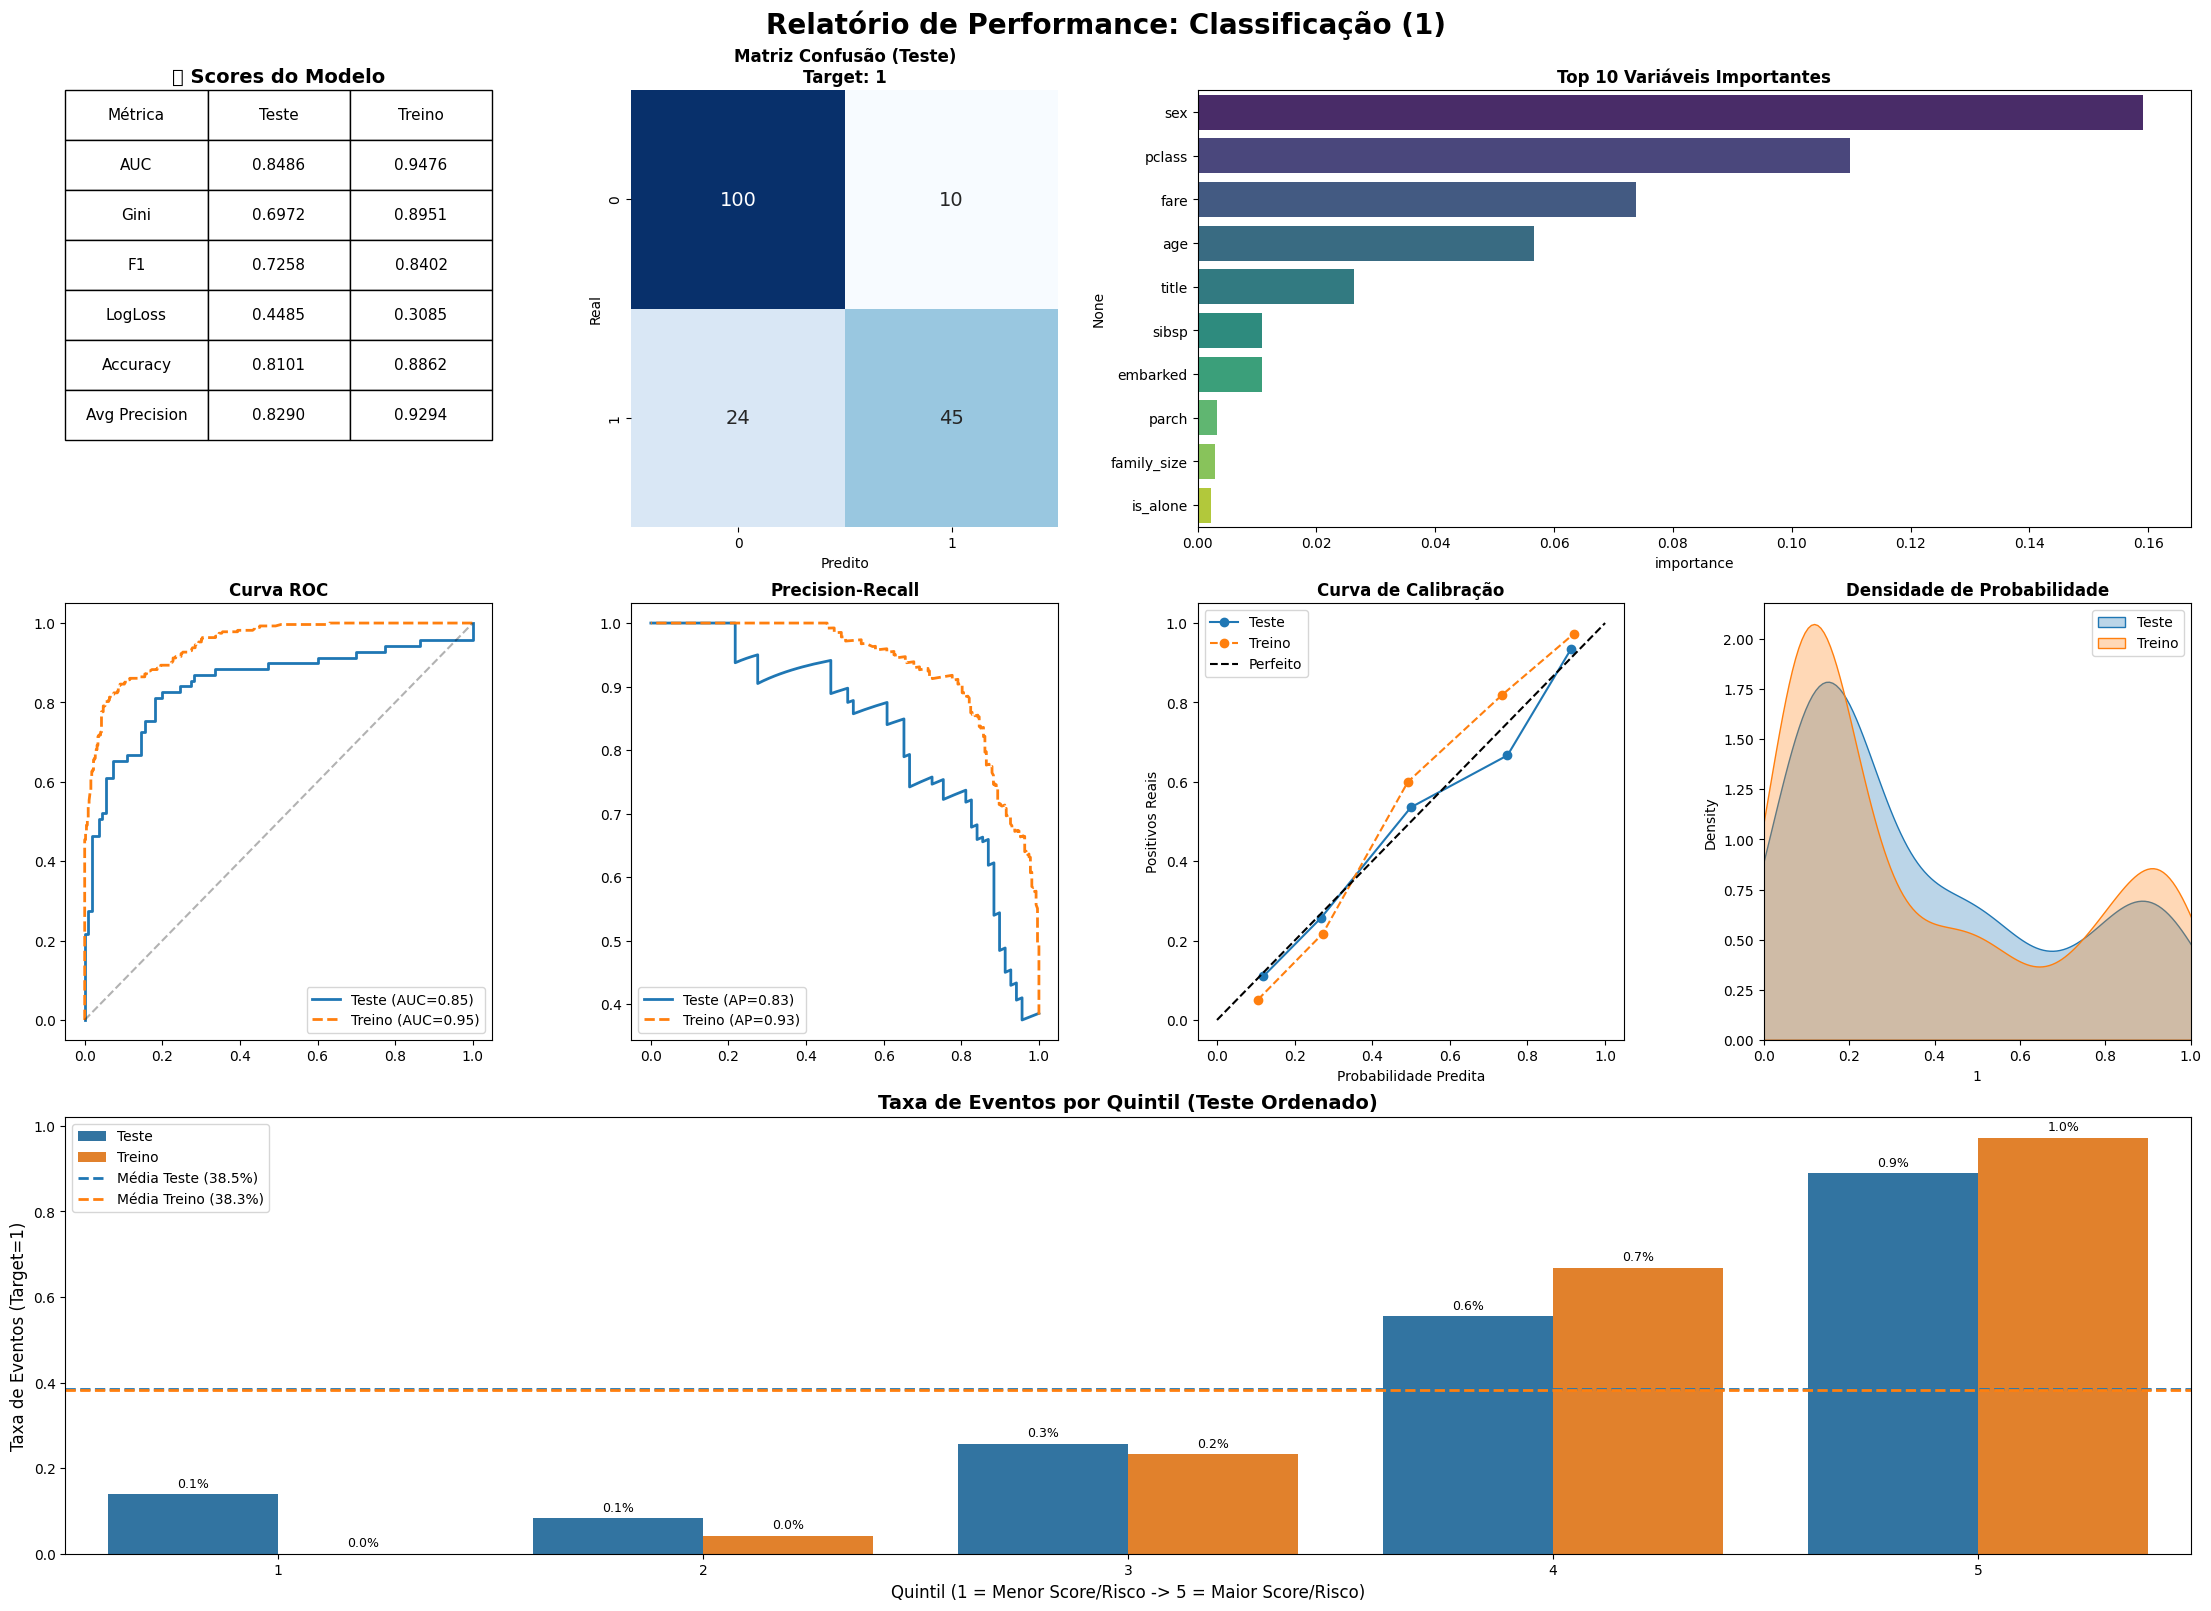

📦 Bundle salvo em modelo_titanic_prod

✅ Processo concluído! Verifique se as barras azuis agora estão crescentes.


In [4]:
def load_and_prep_titanic():
    print("🚢 Carregando Dataset Titanic ORIGINAL (Raw CSV)...")
    url = (
        "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    )
    df = pd.read_csv(url)
    df.columns = [c.lower() for c in df.columns]

    for col in df.select_dtypes(["object", "category"]).columns:
        df[col] = df[col].astype(str)

    print("✨ Criando Features Derivadas...")
    df["title"] = df["name"].str.extract(" ([A-Za-z]+)\.", expand=False)
    rare = [
        "Lady",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ]
    df["title"] = df["title"].replace(rare, "Rare")
    df["title"] = df["title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    df["family_size"] = df["sibsp"] + df["parch"] + 1
    df["is_alone"] = (df["family_size"] == 1).astype(int)

    return df


# --- EXECUÇÃO ---
df = load_and_prep_titanic()
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["survived"]
)

params = {
    "target": "survived",
    # CRÍTICO: Remover 'ticket' e 'cabin' para reduzir overfitting e melhorar ordenação do teste
    "features_to_exclude": ["passengerid", "ticket", "cabin"],
    "pipeline_settings": {"use_pca": False, "pca_components": 0.95},
    "force_types": {"category": ["sex", "embarked", "pclass", "title"]},
    "eval_metric": "average_precision",
    # CRÍTICO: Usar 'high_quality' evita modelos complexos demais que decoram o treino
    "presets": "high_quality",
}

print("\n⚙️ Inicializando Engine...")
engine = AutoClassificationEngine(params)

# Treinar
leaderboard = engine.fit(train_df, time_limit=60)

print("\n🏆 Top 5 Modelos:")
print(leaderboard[["model", "score_val", "pred_time_val"]].head(5))

# Relatório Visual
print("\n📊 Gerando Relatório Visual (Quintis para Suavização)...")
# TRUQUE VISUAL: bins=5 (Quintis) em vez de 10.
# Como a base de teste é pequena (~180), usar 5 faixas garante ordenação visual melhor.
engine.plot_complete_report(test_df, train_data=train_df, bins=5)

engine.save_bundle("modelo_titanic_prod")
print("\n✅ Processo concluído! Verifique se as barras azuis agora estão crescentes.")

📊 Carregando Dataset Adult Income (UCI Machine Learning Repository)...
   Dimensões originais: (32561, 16)
   Taxa da classe Positiva (>50K): 24.08%

⚙️ Inicializando Engine...

🚀 --- TREINAMENTO INICIADO ---

📋 RESUMO DA FILTRAGEM DE VARIÁVEIS:
   => Removidas por Leakage (100% obvias): Nenhuma
   => Removidas por Alta Cardinalidade:    Nenhuma
   => Removidas por Colinearidade (>90%):  Nenhuma
   => Features Finais Mantidas (12): ['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


No path specified. Models will be saved in: "AutogluonModels/ag-20260219_133932"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.2.0: Tue Nov 18 21:08:48 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T8132
CPU Count:          10
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       6.94 GB / 16.00 GB (43.4%)
Disk Space Avail:   373.05 GB / 460.43 GB (81.0%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "/Users/gabrielsales/Documents/Projetos/tpot_examspred/AutogluonModels/ag-20260219_133932"
Train Data Rows:    26048
Train Data Columns: 12
Label Co


🎯 Métrica Otimizada: f1 | Preset: medium_quality


	Available Memory:                    7114.33 MB
	Train Data (Original)  Memory Usage: 12.55 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])  : 5 | ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
		('object', []) : 7 | ['workclass', 'marital-status', 'occupation', 'relationship', 'race', ...]
	Ty


✅ Modelo Treinado.

🏆 Top 5 Modelos:
                 model  score_val  pred_time_val
0     RandomForestEntr   0.681416       0.054693
1     RandomForestGini   0.686779       0.039848
2       ExtraTreesGini   0.680739       0.054380
3       ExtraTreesEntr   0.681416       0.068675
4  WeightedEnsemble_L2   0.738786       0.175624

📊 Gerando Relatório Visual (10 Decis)...


/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/gabrielsales/Documents/Projetos/tpot_examspred/src/meu_framework.py:386: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


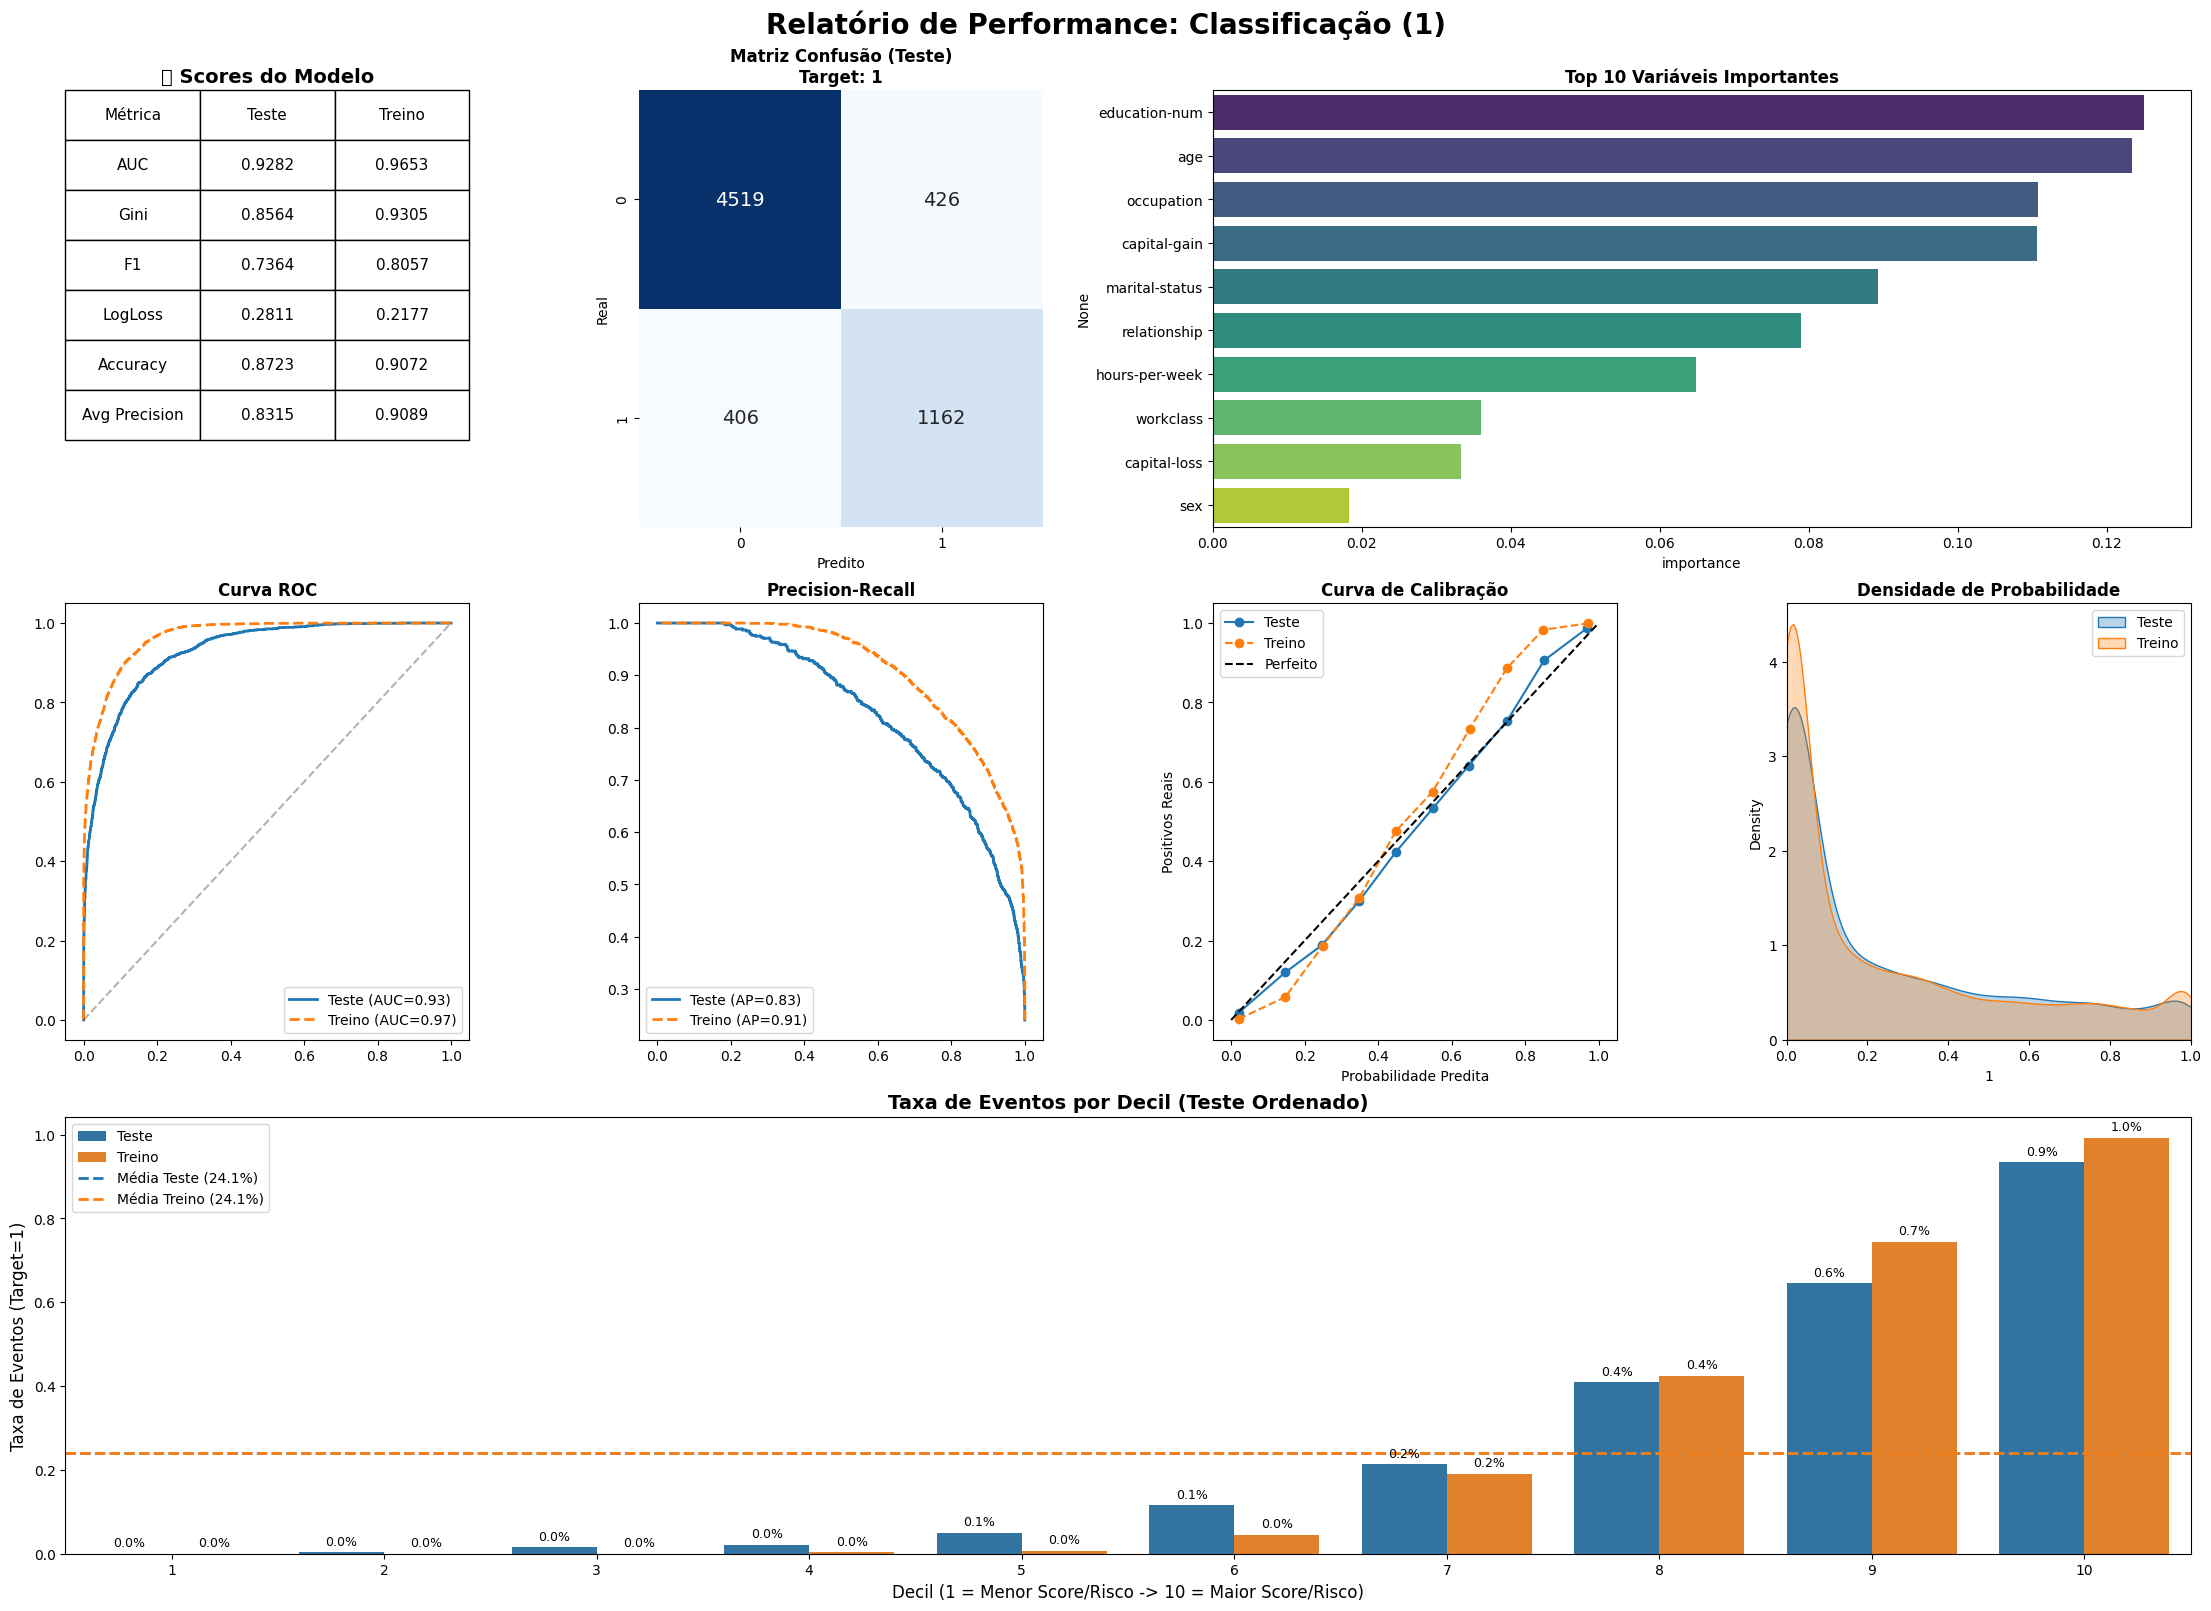

📦 Bundle salvo em modelo_adult_prod

✅ Processo concluído! Verifique as variáveis mais importantes (Geralmente Idade, Casamento e Ganho de Capital).


In [5]:
def load_and_prep_adult():
    print("📊 Carregando Dataset Adult Income (UCI Machine Learning Repository)...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

    # Nomes das colunas conforme a documentação oficial
    columns = [
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income",
    ]

    df = pd.read_csv(url, names=columns, sep=",\s*", engine="python")

    # Substituir os "?" (usados nesse dataset para nulos) pelo padrão np.nan
    df = df.replace("?", np.nan)

    # O target original é '<=50K' e '>50K'. Vamos binarizar para facilitar a leitura no report.
    # 1 = Ganha >50K (Nossa classe de interesse/alvo)
    # 0 = Ganha <=50K
    df["target"] = (df["income"] == ">50K").astype(int)

    print(f"   Dimensões originais: {df.shape}")
    print(f"   Taxa da classe Positiva (>50K): {df['target'].mean():.2%}")

    return df


# --- EXECUÇÃO ---
df = load_and_prep_adult()

# Divisão Treino/Teste
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["target"]
)

params = {
    "target": "target",
    # features_to_exclude:
    # - 'income': A coluna original de texto (evitar data leakage).
    # - 'fnlwgt': É um peso amostral do censo, costuma adicionar ruído.
    # - 'education': É redundante, pois 'education-num' já traz a mesma info de forma ordinal numérica.
    "features_to_exclude": ["income", "fnlwgt", "education"],
    "pipeline_settings": {
        "use_pca": False,
    },
    "force_types": {
        "category": [
            "workclass",
            "marital-status",
            "occupation",
            "relationship",
            "race",
            "sex",
            "native-country",
        ]
    },
    # ROC AUC é excelente para problemas de desbalanceamento moderado
    "eval_metric": "f1",
    # 'medium_quality' é recomendado aqui pois a base já tem 32k linhas.
    # 'high_quality' demoraria bastante tempo.
    "presets": "medium_quality",
}

print("\n⚙️ Inicializando Engine...")
engine = AutoClassificationEngine(params)

# Treinar - Como a base é maior, vamos dar 120 segundos para ele testar mais modelos
leaderboard = engine.fit(train_df, time_limit=120)

print("\n🏆 Top 5 Modelos:")
print(leaderboard[["model", "score_val", "pred_time_val"]].head(5))

# Relatório Visual
print("\n📊 Gerando Relatório Visual (10 Decis)...")
# Como o teste tem >6.000 linhas, 10 bins (Decis) funcionarão perfeitamente e sem ruído!
engine.plot_complete_report(test_df, train_data=train_df, bins=10)

engine.save_bundle("modelo_adult_prod")
print(
    "\n✅ Processo concluído! Verifique as variáveis mais importantes (Geralmente Idade, Casamento e Ganho de Capital)."
)